In [1]:
import csv
import pandas as pd
import shap
import sklearn
import numpy as np
import matplotlib
import interpret.glassbox
import xgboost
import time
import matplotlib.pylab as pl
from hyperopt.pyll.base import scope
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import KFold
from xgbse.converters import (
    convert_data_to_xgb_format,
    convert_to_structured
)

# Hyperparameters tuning

from hyperopt import STATUS_OK, fmin, hp, tpe, SparkTrials

data = pd.read_csv('../cohort.csv')
# https://github.com/IyarLin/survXgboost get predictions instead of hazards

pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [2]:
# data = data.sample(50000)
y = data
y = convert_to_structured(y['time'], y['event'])
y = [x[1] if x[0] else -x[1] for x in y]
X = data.drop(['time', 'event', 'charlson', 'cldl', 'htn_med', 'c10'], axis = 1)
event = data['time']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=20)
X_train, X_test, event_train, event_test = train_test_split(X, event, test_size=0.2, random_state=20)

In [3]:
def c_statistic_harrell(pred, labels):
    total = 0
    matches = 0
    for i in range(len(labels)):
        for j in range(len(labels)):
            if int(labels[j]) > 0 and abs(int(labels[i])) > int(labels[j]):
                total += 1
                if pred[j] > pred[i]:
                    matches += 1
    return matches/total

In [44]:
SEED = 314159265
VALID_SIZE = 0.2
TARGET = 'outcome'
##############################################
def score_xgb(params):
    print("Training with params: ")
    print(params)
    
    n_folds = 5
    val_scores = []
    skf = KFold(n_splits = n_folds, shuffle = False)
    num_boost_round=1000
    #k-fold CV
    for train_index, val_index in skf.split(X_train): 
        X_tr, X_val = X_train.iloc[train_index], X_train.iloc[val_index]
        y_tr, y_val = event.iloc[train_index], event.iloc[val_index]
        
        dtrain = xgboost.DMatrix(X_tr, label=y_tr)
        dval = xgboost.DMatrix(X_val, label=y_val)

        watchlist = [(dval, 'eval'), (dtrain, 'train')]
        gbm_model = xgboost.train(params, dtrain, num_boost_round,
                              evals=watchlist,
                                 verbose_eval=500)
        
        predictions = gbm_model.predict(dval,
                                    ntree_limit=gbm_model.best_iteration + 1)
        val_scores.append(c_statistic_harrell(predictions, list(y_val)))
    
    score = np.mean(val_scores) #Objective: maximize mean 5-fold CV C-index 
    
    print("\tScore {0}\n\n".format(score))
    # The score function should return the loss (1-score)
    # since the optimize function looks for the minimum
    loss = 1 - score
    return {'loss': loss, 'status': STATUS_OK}


def optimize_xgb(score, 
             random_state=SEED):
    """
    This is the optimization function that given a space of 
    hyperparameters and a scoring function, finds the best hyperparameters.
    """

    # exception: min_child_weight, reg_alpha and reg_lambda capped at 10 rather than 100
    space = {
        'eta':                         hp.loguniform('eta', np.log(0.01), np.log(0.1)),
        'max_depth':                   scope.int(hp.quniform('max_depth', 2,3,1)),
        'min_child_weight':            hp.loguniform('min_child_weight', np.log(0.1), np.log(1)),
        'reg_alpha':                   hp.loguniform('reg_alpha', np.log(0.1), np.log(1)),
        'reg_lambda':                  hp.loguniform('reg_lambda', np.log(0.1), np.log(1)),
        'subsample':                   hp.uniform('subsample', 0.75, 1),
        "objective": "survival:cox",
        "predictor": "gpu_predictor"
    }
    
    # Use the fmin function from Hyperopt to find the best hyperparameters
    best = fmin(score, space, algo=tpe.suggest, 
                max_evals=100)
    return best

In [45]:
print("---- Running XGBoost ----")
start=time.time()
xgb_best_hyperparams = optimize_xgb(score_xgb)
end=time.time()
print("Done: took", (end-start)/60, "minutes")
print("---- Results for XGBoost ----")
print("The best hyperparameters are: ", "\n")
print(xgb_best_hyperparams)

---- Running XGBoost ----
Training with params:                                                           
{'eta': 0.08421475269875413, 'max_depth': 2, 'min_child_weight': 0.30989401914860504, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.4497622294735796, 'reg_lambda': 0.4448942812029034, 'subsample': 0.9749766557190264}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62442	train-cox-nloglik:11.00693                       
[999]	eval-cox-nloglik:9.62451	train-cox-nloglik:11.00689                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62252	train-cox-nloglik:11.00751                       
[999]	eval-cox-nloglik:9.62254	train-cox-nloglik:11.00750                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62011	train-cox-nloglik:11.00806                       


Training with params:                                                           
{'eta': 0.0276679413221383, 'max_depth': 3, 'min_child_weight': 0.16723223937066922, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.8092257393373689, 'reg_lambda': 0.4472375647453353, 'subsample': 0.8082119963178525}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62447	train-cox-nloglik:11.00645                       
[999]	eval-cox-nloglik:9.62494	train-cox-nloglik:11.00596                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62265	train-cox-nloglik:11.00691                       
[999]	eval-cox-nloglik:9.62301	train-cox-nloglik:11.00643                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62026	train-cox-nloglik:11.00746                       
[999]	eval-cox-nloglik:9.62

Training with params:                                                           
{'eta': 0.017079264849212315, 'max_depth': 2, 'min_child_weight': 0.16839622148346872, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.3170975960796048, 'reg_lambda': 0.768895179528807, 'subsample': 0.9019683843754835}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62411	train-cox-nloglik:11.00708                       
[999]	eval-cox-nloglik:9.62429	train-cox-nloglik:11.00691                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62233	train-cox-nloglik:11.00755                       
[999]	eval-cox-nloglik:9.62247	train-cox-nloglik:11.00741                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.61974	train-cox-nloglik:11.00821                       
[999]	eval-cox-nloglik:9.6

Training with params:                                                           
{'eta': 0.03889326333911383, 'max_depth': 2, 'min_child_weight': 0.12937429985470442, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.7729096791177612, 'reg_lambda': 0.1534400082861209, 'subsample': 0.955166303213761}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62428	train-cox-nloglik:11.00701                       
[999]	eval-cox-nloglik:9.62436	train-cox-nloglik:11.00694                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62241	train-cox-nloglik:11.00756                       
[999]	eval-cox-nloglik:9.62245	train-cox-nloglik:11.00752                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.61987	train-cox-nloglik:11.00813                       
[999]	eval-cox-nloglik:9.61

Training with params:                                                           
{'eta': 0.08439227384802764, 'max_depth': 3, 'min_child_weight': 0.6307409265132762, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.11337234880987304, 'reg_lambda': 0.10908315761529404, 'subsample': 0.7855892458278131}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00735                         
[500]	eval-cox-nloglik:9.62807	train-cox-nloglik:11.00460                       
[999]	eval-cox-nloglik:9.63140	train-cox-nloglik:11.00290                       
[0]	eval-cox-nloglik:9.62226	train-cox-nloglik:11.00778                         
[500]	eval-cox-nloglik:9.62566	train-cox-nloglik:11.00519                       
[999]	eval-cox-nloglik:9.62888	train-cox-nloglik:11.00348                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00848                         
[500]	eval-cox-nloglik:9.62421	train-cox-nloglik:11.00571                       
[999]	eval-cox-nloglik:9.

Training with params:                                                           
{'eta': 0.062372103721215814, 'max_depth': 3, 'min_child_weight': 0.23950351823323474, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.9994788551322321, 'reg_lambda': 0.6870495332372805, 'subsample': 0.7520988633246635}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62504	train-cox-nloglik:11.00619                       
[999]	eval-cox-nloglik:9.62553	train-cox-nloglik:11.00578                       
[0]	eval-cox-nloglik:9.62221	train-cox-nloglik:11.00779                         
[500]	eval-cox-nloglik:9.62314	train-cox-nloglik:11.00668                       
[999]	eval-cox-nloglik:9.62355	train-cox-nloglik:11.00623                       
[0]	eval-cox-nloglik:9.61948	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62068	train-cox-nloglik:11.00739                       
[999]	eval-cox-nloglik:9.

Training with params:                                                           
{'eta': 0.07772884694995201, 'max_depth': 3, 'min_child_weight': 0.29493082983544294, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.2083957013634086, 'reg_lambda': 0.10001904224871207, 'subsample': 0.8213315562851048}
[0]	eval-cox-nloglik:9.62393	train-cox-nloglik:11.00735                         
[500]	eval-cox-nloglik:9.62823	train-cox-nloglik:11.00436                       
[999]	eval-cox-nloglik:9.63171	train-cox-nloglik:11.00253                       
[0]	eval-cox-nloglik:9.62224	train-cox-nloglik:11.00779                         
[500]	eval-cox-nloglik:9.62526	train-cox-nloglik:11.00511                       
[999]	eval-cox-nloglik:9.62784	train-cox-nloglik:11.00335                       
[0]	eval-cox-nloglik:9.61948	train-cox-nloglik:11.00847                         
[500]	eval-cox-nloglik:9.62504	train-cox-nloglik:11.00539                       
[999]	eval-cox-nloglik:9.

Training with params:                                                           
{'eta': 0.05808268207652372, 'max_depth': 3, 'min_child_weight': 0.6653021728336772, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.4388640319829586, 'reg_lambda': 0.21506841979410357, 'subsample': 0.793022188309287}
[0]	eval-cox-nloglik:9.62392	train-cox-nloglik:11.00736                         
[500]	eval-cox-nloglik:9.62580	train-cox-nloglik:11.00544                       
[999]	eval-cox-nloglik:9.62781	train-cox-nloglik:11.00404                       
[0]	eval-cox-nloglik:9.62223	train-cox-nloglik:11.00779                         
[500]	eval-cox-nloglik:9.62383	train-cox-nloglik:11.00594                       
[999]	eval-cox-nloglik:9.62527	train-cox-nloglik:11.00469                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62198	train-cox-nloglik:11.00637                       
[999]	eval-cox-nloglik:9.62

Training with params:                                                           
{'eta': 0.07034940412824164, 'max_depth': 3, 'min_child_weight': 0.13619107340819098, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.9059870225171651, 'reg_lambda': 0.287027371283272, 'subsample': 0.8077952806986174}
[0]	eval-cox-nloglik:9.62393	train-cox-nloglik:11.00736                         
[500]	eval-cox-nloglik:9.62528	train-cox-nloglik:11.00585                       
[999]	eval-cox-nloglik:9.62601	train-cox-nloglik:11.00531                       
[0]	eval-cox-nloglik:9.62223	train-cox-nloglik:11.00779                         
[500]	eval-cox-nloglik:9.62338	train-cox-nloglik:11.00637                       
[999]	eval-cox-nloglik:9.62403	train-cox-nloglik:11.00580                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00848                         
[500]	eval-cox-nloglik:9.62135	train-cox-nloglik:11.00687                       
[999]	eval-cox-nloglik:9.62

Training with params:                                                           
{'eta': 0.04867695960616739, 'max_depth': 2, 'min_child_weight': 0.11989696841009463, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.6729904125821918, 'reg_lambda': 0.9591619851322666, 'subsample': 0.8965971817760856}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62424	train-cox-nloglik:11.00702                       
[999]	eval-cox-nloglik:9.62432	train-cox-nloglik:11.00695                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62249	train-cox-nloglik:11.00751                       
[999]	eval-cox-nloglik:9.62255	train-cox-nloglik:11.00743                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.61986	train-cox-nloglik:11.00814                       
[999]	eval-cox-nloglik:9.6

Training with params:                                                           
{'eta': 0.039239209106248764, 'max_depth': 2, 'min_child_weight': 0.14970609235294335, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.716073722856179, 'reg_lambda': 0.34313844823187645, 'subsample': 0.9447734005661632}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62422	train-cox-nloglik:11.00701                       
[999]	eval-cox-nloglik:9.62430	train-cox-nloglik:11.00695                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62242	train-cox-nloglik:11.00754                       
[999]	eval-cox-nloglik:9.62245	train-cox-nloglik:11.00749                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.61984	train-cox-nloglik:11.00812                       
[999]	eval-cox-nloglik:9.

Training with params:                                                           
{'eta': 0.08890485295280232, 'max_depth': 2, 'min_child_weight': 0.19316691746016584, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.40138169392849743, 'reg_lambda': 0.5285707828179002, 'subsample': 0.7868177024167574}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62506	train-cox-nloglik:11.00655                       
[999]	eval-cox-nloglik:9.62613	train-cox-nloglik:11.00610                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62337	train-cox-nloglik:11.00708                       
[999]	eval-cox-nloglik:9.62410	train-cox-nloglik:11.00660                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62091	train-cox-nloglik:11.00760                       
[999]	eval-cox-nloglik:9.

Training with params:                                                           
{'eta': 0.041996160392669575, 'max_depth': 2, 'min_child_weight': 0.2880740107100339, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.4469010562358445, 'reg_lambda': 0.4519197501210483, 'subsample': 0.8838647311908364}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62446	train-cox-nloglik:11.00687                       
[999]	eval-cox-nloglik:9.62494	train-cox-nloglik:11.00658                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62258	train-cox-nloglik:11.00737                       
[999]	eval-cox-nloglik:9.62294	train-cox-nloglik:11.00710                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62012	train-cox-nloglik:11.00793                       
[999]	eval-cox-nloglik:9.6

Training with params:                                                           
{'eta': 0.06642520750469252, 'max_depth': 2, 'min_child_weight': 0.27737006195858754, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.1000632473059433, 'reg_lambda': 0.32586643886836264, 'subsample': 0.7993968307730713}
[0]	eval-cox-nloglik:9.62393	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62505	train-cox-nloglik:11.00655                       
[999]	eval-cox-nloglik:9.62625	train-cox-nloglik:11.00607                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62306	train-cox-nloglik:11.00714                       
[999]	eval-cox-nloglik:9.62370	train-cox-nloglik:11.00674                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62088	train-cox-nloglik:11.00767                       
[999]	eval-cox-nloglik:9.

Training with params:                                                           
{'eta': 0.05076924343545629, 'max_depth': 2, 'min_child_weight': 0.20994492208465493, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.25168010248018885, 'reg_lambda': 0.44233106969218905, 'subsample': 0.7700822719542648}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62466	train-cox-nloglik:11.00673                       
[999]	eval-cox-nloglik:9.62524	train-cox-nloglik:11.00637                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62267	train-cox-nloglik:11.00726                       
[999]	eval-cox-nloglik:9.62311	train-cox-nloglik:11.00693                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62035	train-cox-nloglik:11.00782                       
[999]	eval-cox-nloglik:9

Training with params:                                                           
{'eta': 0.040166994391586594, 'max_depth': 2, 'min_child_weight': 0.29288508031410787, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.3171931491317824, 'reg_lambda': 0.24112453051849997, 'subsample': 0.8201388152075716}
[0]	eval-cox-nloglik:9.62393	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62453	train-cox-nloglik:11.00681                       
[999]	eval-cox-nloglik:9.62515	train-cox-nloglik:11.00644                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62272	train-cox-nloglik:11.00735                       
[999]	eval-cox-nloglik:9.62312	train-cox-nloglik:11.00705                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62035	train-cox-nloglik:11.00789                       
[999]	eval-cox-nloglik:9

Training with params:                                                           
{'eta': 0.05010912443723036, 'max_depth': 3, 'min_child_weight': 0.41965684995645913, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.5961140190149207, 'reg_lambda': 0.4043186879581688, 'subsample': 0.9289714380611308}
[0]	eval-cox-nloglik:9.62393	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62477	train-cox-nloglik:11.00627                       
[999]	eval-cox-nloglik:9.62494	train-cox-nloglik:11.00605                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62277	train-cox-nloglik:11.00683                       
[999]	eval-cox-nloglik:9.62283	train-cox-nloglik:11.00668                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62045	train-cox-nloglik:11.00736                       
[999]	eval-cox-nloglik:9.6

Training with params:                                                           
{'eta': 0.03372518312808484, 'max_depth': 2, 'min_child_weight': 0.14372966484736477, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.7588070562194785, 'reg_lambda': 0.579449615820233, 'subsample': 0.8288286847778427}
[0]	eval-cox-nloglik:9.62393	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62423	train-cox-nloglik:11.00699                       
[999]	eval-cox-nloglik:9.62445	train-cox-nloglik:11.00679                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62254	train-cox-nloglik:11.00746                       
[999]	eval-cox-nloglik:9.62270	train-cox-nloglik:11.00730                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.61993	train-cox-nloglik:11.00806                       
[999]	eval-cox-nloglik:9.62

Training with params:                                                           
{'eta': 0.0635823337496856, 'max_depth': 2, 'min_child_weight': 0.12040540532630059, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.41934524780578525, 'reg_lambda': 0.4168073666073731, 'subsample': 0.7919556018303042}
[0]	eval-cox-nloglik:9.62393	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62476	train-cox-nloglik:11.00666                       
[999]	eval-cox-nloglik:9.62560	train-cox-nloglik:11.00629                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62289	train-cox-nloglik:11.00715                       
[999]	eval-cox-nloglik:9.62352	train-cox-nloglik:11.00681                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62042	train-cox-nloglik:11.00776                       
[999]	eval-cox-nloglik:9.6

Training with params:                                                           
{'eta': 0.019220964055667363, 'max_depth': 3, 'min_child_weight': 0.16548031653842887, 'objective': 'survival:cox', 'predictor': 'gpu_predictor', 'reg_alpha': 0.5691820938525307, 'reg_lambda': 0.5547184134957003, 'subsample': 0.8205277992498754}
[0]	eval-cox-nloglik:9.62394	train-cox-nloglik:11.00737                         
[500]	eval-cox-nloglik:9.62434	train-cox-nloglik:11.00656                       
[999]	eval-cox-nloglik:9.62477	train-cox-nloglik:11.00602                       
[0]	eval-cox-nloglik:9.62222	train-cox-nloglik:11.00780                         
[500]	eval-cox-nloglik:9.62250	train-cox-nloglik:11.00706                       
[999]	eval-cox-nloglik:9.62283	train-cox-nloglik:11.00656                       
[0]	eval-cox-nloglik:9.61947	train-cox-nloglik:11.00849                         
[500]	eval-cox-nloglik:9.62006	train-cox-nloglik:11.00761                       
[999]	eval-cox-nloglik:9.

100%|███| 100/100 [14:06:01<00:00, 507.61s/trial, best loss: 0.4955569803437333]
Done: took 846.0185748020808 minutes
---- Results for XGBoost ----
The best hyperparameters are:  

{'eta': 0.06762699363611696, 'max_depth': 3.0, 'min_child_weight': 0.20842058329380173, 'reg_alpha': 0.6022332107335537, 'reg_lambda': 0.35196063054332594, 'subsample': 0.7505628222490803}


In [50]:
# {'eta': 0.06762699363611696, 'max_depth': 3.0, 'min_child_weight': 0.20842058329380173, 
# 'reg_alpha': 0.6022332107335537, 'reg_lambda': 0.35196063054332594, 'subsample': 0.7505628222490803}
params = {
    'eta': 0.07,
    "max_depth": 3,
    'min_child_weight': 0.2,
    'reg_alpha': 0.6,
    'reg_lambda': 0.51,
    "objective": "survival:cox",
    "subsample":  0.75,
    "predictor": "gpu_predictor"
}

In [51]:
num_boost_round=100000
dtrain = xgboost.DMatrix(X_train, label=y_train)
dval = xgboost.DMatrix(X_test, label=y_test)

watchlist = [(dtrain, 'train'), (dval, 'eval')]
# watchlist = [(dval, 'eval')]
# evals=[(train, "train"), (test, "validation")]
xgb_model = xgboost.train(params, 
                          dtrain, 
                          num_boost_round, 
                          early_stopping_rounds=1000,
                          evals=watchlist,
                          verbose_eval=500)

predictions = xgb_model.predict(dval, ntree_limit=xgb_model.best_iteration + 1)



xgb_test_score = c_statistic_harrell(predictions, list(y_test))
print("XGB Done:", xgb_test_score)
# 0.659

[0]	train-cox-nloglik:11.29691	eval-cox-nloglik:9.90987
[500]	train-cox-nloglik:11.01852	eval-cox-nloglik:9.78645
[1000]	train-cox-nloglik:10.93387	eval-cox-nloglik:9.80790
[1123]	train-cox-nloglik:10.91504	eval-cox-nloglik:9.81251
XGB Done: 0.6593222535793425


In [52]:
xgb_model.best_iteration

123

In [53]:
# save to JSON
xgb_model.save_model("model_all.json")

In [ ]:
# xgb_model = xgboost.Booster()
# xgb_model.load_model("model_all.json")

In [54]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X)

In [55]:
matplotlib.use('tkagg',force=True)
from matplotlib import pyplot as plt
matplotlib.get_backend()
%matplotlib inline

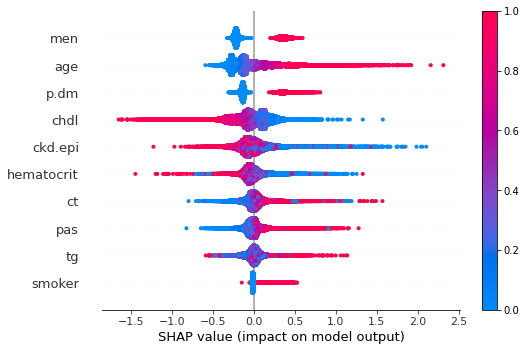

In [56]:
shap.summary_plot(shap_values, X, show=False, color_bar=False)
plt.colorbar()

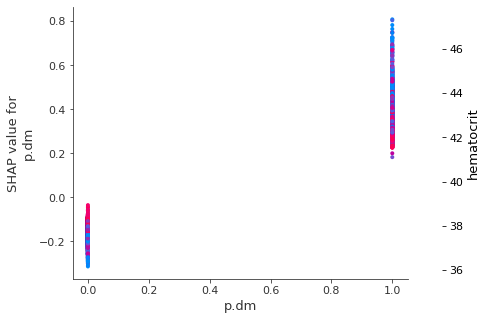

In [59]:
shap.dependence_plot("p.dm", shap_values, X)

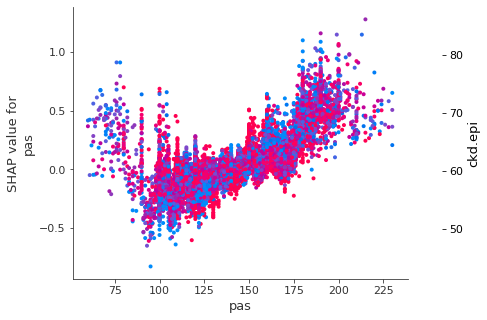

In [58]:
shap.dependence_plot("pas", shap_values, X)

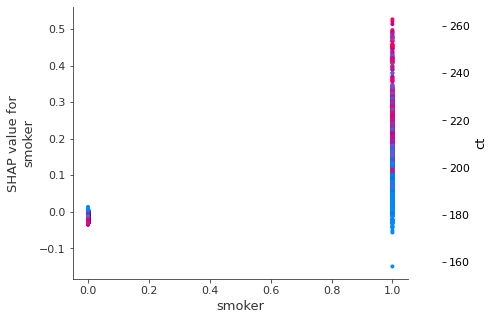

In [57]:
shap.dependence_plot("smoker", shap_values, X)

In [60]:
age = input('age:')
men = input('sex (1 for men, 0 for women):')
smoker = input('smoker (1 is smoker, 0 not smoker):')
pdm = input ('diabetes (1 is diabetic, 0 is not):')
pas = input('pas:')
ct = input('ct:')
chdl = input('chdl:')
tg = input('tg:')
# htn_med=input('hypertensive treatment (1 is being treated, 0 not):')
# charlson=input('charlson:')
ckdepi=input('renal function:')
# c10 = input('lipid-lowering treatment (1 is being treated, 0 not):')
hematocrit = input('hematocrit:')

df2 = {'age': float(age),
       'men': float(men), 
       'smoker': float(smoker),
       'p.dm': float(pdm),
       'pas': float(pas),
       'ct': float(ct),
       'chdl': float(chdl),
       'tg':float(tg),
       # 'htn_med':float(htn_med),
       # 'charlson':float(charlson),
       'ckd.epi':float(ckdepi),
       # 'c10':float(c10),
       'hematocrit':float(hematocrit)}

X = X.append(df2, ignore_index = True)

shap.initjs()
explainerModel = shap.TreeExplainer(xgb_model)
shap_values_Model = explainerModel.shap_values(X.iloc[[-1]])
a = shap.force_plot(explainerModel.expected_value, shap_values_Model[-1], X.iloc[[-1]])

X.drop(X.tail(1).index,inplace=True)

age:76
sex (1 for men, 0 for women):0
smoker (1 is smoker, 0 not smoker):1
diabetes (1 is diabetic, 0 is not):0
pas:100
ct:160
chdl:95
tg:111
renal function:65
hematocrit:43


The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.


pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.


In [61]:
a

In [19]:
X

,age,men,smoker,p.dm,pas,ct,chdl,tg,ckd.epi,hematocrit
0,76,0,0,0,115.0,199,65,63,71.290591,42.4
1,76,0,0,0,149.0,224,45,200,82.309140,40.8
2,79,1,0,0,130.0,210,33,246,54.415764,46.7
3,83,0,0,0,146.0,291,114,111,55.387302,39.8
4,78,0,0,1,145.0,217,46,112,81.160845,43.4
...,...,...,...,...,...,...,...,...,...,...
109298,77,0,0,0,132.0,304,97,109,67.039212,39.0
109299,75,0,0,0,143.0,212,69,70,78.477076,43.8
109300,85,0,0,0,178.0,166,58,93,77.266511,42.4
109301,85,1,0,0,110.0,165,49,75,73.727877,38.2
